In [ ]:
%matplotlib inline

import gc
import pdet
import fpfs
import fitsio
import pltutil
import numpy as np
import numpy.lib.recfunctions as rfn
import matplotlib.pylab as plt

ver='try2'
gver='basic2'
wrkDir=os.environ['homeWrk']
simDir=os.path.join(wrkDir,'FPFS2/sim/')
# merge data from n fields
out1=[]
out2=[]
for _i in range(400):
    _a1=fitsio.read(os.path.join(simDir,'src_%sCenter-var4em3_%s/psf60/fpfs-cut16-%04d-g1-0000.fits' %(gver,ver,_i)))
    _a2=fitsio.read(os.path.join(simDir,'src_%sCenter-var4em3_%s/psf60/fpfs-cut16-%04d-g1-2222.fits' %(gver,ver,_i)))
    out1.append(_a1)
    out2.append(_a2)
    del _a1,_a2
    

_default_inds=[(1,2),(2,1),(2,2),(2,3),(3,2)]

def fpfsM2E(moments,dets=None,const=1.,noirev=False):
    """
    Estimate FPFS ellipticities from fpfs moments

    Parameters:
    ----
    moments:    input FPFS moments     [ndarray]
    dets:       input detection array  [ndarray (default: None)]
    const:      the _wing Constant [float (default:1)]
    noirev:     revise the second-order noise bias? [bool (default: False)]

    Returns:
    ----
    out:        an array of (FPFS ellipticities, FPFS ellipticity response,
                FPFS flux ratio, and FPFS selection response)
    """
    types   =   [('fpfs_e1','>f8'), ('fpfs_e2','>f8'),      ('fpfs_RE','>f8'),\
                ('fpfs_s0','>f8') , ('fpfs_eSquare','>f8'), ('fpfs_RS','>f8')]
    # response for selections (2 shear components for each)
    #Get inverse weight
    _w      =   moments['fpfs_M00']+const
    #Ellipticity
    e1      =   moments['fpfs_M22c']/_w
    e2      =   moments['fpfs_M22s']/_w
    e1sq    =   e1*e1
    e2sq    =   e2*e2
    #FPFS flux ratio
    s0      =   moments['fpfs_M00']/_w
    s4      =   moments['fpfs_M40']/_w
    #FPFS sel Respose (part1)
    e1sqS0  =   e1sq*s0
    e2sqS0  =   e2sq*s0

    # prepare the shear response for detection operation
    if dets is not None:
        dDict=  {}
        for (j,i) in _default_inds:
            types.append(('fpfs_e1v%d%dr1'%(j,i),'>f8'))
            types.append(('fpfs_e2v%d%dr2'%(j,i),'>f8'))
            dDict['fpfs_e1v%d%dr1' %(j,i)]=e1*dets['pdet_v%d%dr1' %(j,i)]
            dDict['fpfs_e2v%d%dr2' %(j,i)]=e2*dets['pdet_v%d%dr2' %(j,i)]
    else:
        dDict=  None

    if noirev:
        assert 'fpfs_N00N00' in moments.dtype.names
        assert 'fpfs_N00N22c' in moments.dtype.names
        assert 'fpfs_N00N22s' in moments.dtype.names
        ratio=  moments['fpfs_N00N00']/_w**2.

        # correction for detection shear response
        if dDict is not None:
            assert 'pdet_N22cV22r1' in dets.dtype.names
            assert 'pdet_N22sV22r2' in dets.dtype.names
            for (j,i) in _default_inds:
                dDict['fpfs_e1v%d%dr1'%(j,i)]=dDict['fpfs_e1v%d%dr1'%(j,i)]\
                    -1.*dets['pdet_N22cV%d%dr1'%(j,i)]/_w\
                    +1.*e1*dets['pdet_N00V%d%dr1'%(j,i)]/_w\
                    +1.*moments['fpfs_N00N22c']/_w**2.*dets['pdet_v%d%dr1'%(j,i)]
                dDict['fpfs_e1v%d%dr1'%(j,i)]=dDict['fpfs_e1v%d%dr1'%(j,i)]/(1+ratio)
                dDict['fpfs_e2v%d%dr2'%(j,i)]=dDict['fpfs_e2v%d%dr2'%(j,i)]\
                    -1.*dets['pdet_N22sV%d%dr2'%(j,i)]/_w\
                    +1.*e2*dets['pdet_N00V%d%dr2'%(j,i)]/_w\
                    +1.*moments['fpfs_N00N22s']/_w**2.*dets['pdet_v%d%dr2'%(j,i)]
                dDict['fpfs_e2v%d%dr2'%(j,i)]=dDict['fpfs_e2v%d%dr2'%(j,i)]/(1+ratio)

        e1  =   (e1+moments['fpfs_N00N22c']\
                /_w**2.)/(1+ratio)
        e2  =   (e2+moments['fpfs_N00N22s']\
                /_w**2.)/(1+ratio)
        e1sq=   (e1sq-moments['fpfs_N22cN22c']/_w**2.\
                +4.*e1*moments['fpfs_N00N22c']/_w**2.)\
                /(1.+3*ratio)
        e2sq=   (e2sq-moments['fpfs_N22sN22s']/_w**2.\
                +4.*e2*moments['fpfs_N00N22s']/_w**2.)\
                /(1.+3*ratio)
        s0  =   (s0+moments['fpfs_N00N00']\
                /_w**2.)/(1+ratio)
        s4  =   (s4+moments['fpfs_N00N40']\
                /_w**2.)/(1+ratio)

        # correction for selection (by s0) shear response
        e1sqS0= (e1sqS0+3.*e1sq*moments['fpfs_N00N00']/_w**2.\
                -s0*moments['fpfs_N22cN22c']/_w**2.)/(1+6.*ratio)
        e2sqS0= (e2sqS0+3.*e2sq*moments['fpfs_N00N00']/_w**2.\
                -s0*moments['fpfs_N22sN22s']/_w**2.)/(1+6.*ratio)

        gc.collect()

    out  =   np.array(np.zeros(moments.size),dtype=types)
    if dDict is not None:
        for (j,i) in _default_inds:
            out['fpfs_e1v%d%dr1'%(j,i)] = dDict['fpfs_e1v%d%dr1'%(j,i)]
            out['fpfs_e2v%d%dr2'%(j,i)] = dDict['fpfs_e2v%d%dr2'%(j,i)]
        del dDict
        gc.collect()

    eSq     =   e1sq+e2sq
    eSqS0   =   e1sqS0+e2sqS0
    #Response factor
    RE   =   1./np.sqrt(2.)*(s0-s4+e1sq+e2sq)
    out['fpfs_e1']   =   e1
    out['fpfs_e2']   =   e2
    out['fpfs_RE']   =   RE*-1
    out['fpfs_s0']   =   s0
    out['fpfs_eSquare']  =   eSq
    out['fpfs_RS']   =   (eSq-eSqS0)/np.sqrt(2.)
    return out

def get_detbias(dets,ells,cut,dcc,ind):
    """
    Parameters:
    ----
    dets:       detection array
    cut:        selection cut
    dcc:        bin size when estimating marginal density
    inds:       shifting indexes
    """
    fnmv   =  'pdet_v%d%d'  %ind
    fnmr1  =  'fpfs_e1v%d%dr1'%ind
    fnmr2  =  'fpfs_e2v%d%dr2'%ind
    ll     =  cut;uu  =  cut+dcc
    msk    =  (dets[fnmv]>ll)&(dets[fnmv]<uu)
    cor1=np.sum(ells[fnmr1][msk])/dcc
    cor2=np.sum(ells[fnmr2][msk])/dcc
    return cor1,cor2

def get_selbias(ells,cut,dcc):
    """
    Parameters:
    ----
    cut:        selection cut
    dcc:        bin size when estimating marginal density
    inds:       shifting indexes
    """
    fnmv   =  'fpfs_s0'
    fnmr1  =  'fpfs_RS'
    fnmr2  =  'fpfs_RS'
    ll     =  cut;uu  =  cut+dcc
    msk    =  (ells[fnmv]>ll)&(ells[fnmv]<uu)
    cor1=np.sum(ells[fnmr1][msk])/dcc
    cor2=np.sum(ells[fnmr2][msk])/dcc
    return cor1,cor2

def get_detbias_all(dets,ells,cutd,cuts,dcc,ind):
    """
    Parameters:
    ----
    dets:       detection array
    cut:        selection cut
    dcc:        bin size when estimating marginal density
    inds:       shifting indexes
    """
    cord1,cord2=get_detbias(dets,ells,cutd,dcc,ind)
    print(cord1)
    fnmv   =  'pdet_v%d%d'  %ind
    ells2= ells[dets[fnmv]>cutd+dcc]
    cors1,cors2=get_selbias(ells2,cuts,dcc)
    print(cors1)
    return cord1+cors1,cord2+cors2

In [61]:
Const=   4000.
outNN1=[]
outNN2=[]
for _i in range(100):
    _a1=fitsio.read(os.path.join(simDir,'src_%sCenter-var0em0_%s/psf60/fpfs-cut16-%04d-g1-0000.fits' %(gver,ver,_i)))
    _a2=fitsio.read(os.path.join(simDir,'src_%sCenter-var0em0_%s/psf60/fpfs-cut16-%04d-g1-2222.fits' %(gver,ver,_i)))
    outNN1.append(_a1)
    outNN2.append(_a2)
    del _a1,_a2
outNN1 =   rfn.stack_arrays(outNN1,usemask=False)
outNN2 =   rfn.stack_arrays(outNN2,usemask=False)
outDNN1=   pdet.peak2det(outNN1)
outDNN2=   pdet.peak2det(outNN2)

In [62]:
outENN1=   fpfsM2E(outNN1,outDNN1,const=Const,noirev=False)
outENN2=   fpfsM2E(outNN2,outDNN2,const=Const,noirev=False)
del outNN1,outNN2
gc.collect()

0

In [4]:
out1 =   rfn.stack_arrays(out1,usemask=False)
out2 =   rfn.stack_arrays(out2,usemask=False)

outD1=   pdet.peak2det(out1)
outD2=   pdet.peak2det(out2)
outE1=   fpfsM2E(out1,outD1,const=Const,noirev=True)
outE2=   fpfsM2E(out2,outD2,const=Const,noirev=True)

gc.collect()

0

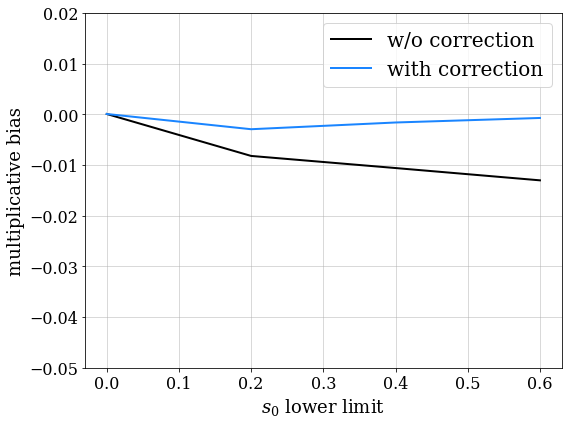

In [24]:
dcc=0.01
x=[]
y1=[]
y2=[]
tt=(2,1)
pn='v%d%d' %tt

xlabel=r'$s_0$'
for i in range(0,4):
    cut=0.2*i
    
    msk1 = (outE1['fpfs_s0']>cut)
    ellM1= outE1[msk1]
    del msk1
    
    msk2 = (outE2['fpfs_s0']>cut)
    ellM2= outE2[msk2]
    del msk2
    
    cor1 = get_selbias(ellM1,cut,dcc)[0]
    cor2 = get_selbias(ellM2,cut,dcc)[0]
    de   = np.sum(ellM2['fpfs_e1'])-np.sum(ellM1['fpfs_e1'])
    rave = (np.sum(ellM2['fpfs_RE'])+np.sum(ellM1['fpfs_RE']))/2.
    raveR= (np.sum(ellM2['fpfs_RE'])+np.sum(ellM1['fpfs_RE'])+cor1+cor2)/2.
    x.append(cut)
    y1.append(de/rave/0.04-1)
    y2.append(de/raveR/0.04-1)
    del ellM1,ellM2
gc.collect()

plt.close()
fig,axes=pltutil.make_figure_axes(1,1)
ax=axes[0]
ax.plot(np.array(x),np.array(y1),label='w/o correction',color=pltutil.colors[0])
ax.plot(np.array(x),np.array(y2),label='with correction',color=pltutil.colors[1])
ax.set_xlabel(xlabel+' lower limit')
ax.set_ylabel('multiplicative bias')
ax.set_ylim(-0.05,0.02)
ax.grid()
ax.legend()
plt.tight_layout()
#fig.savefig('../../html/noisy_knownRef_%s.png' %pn)

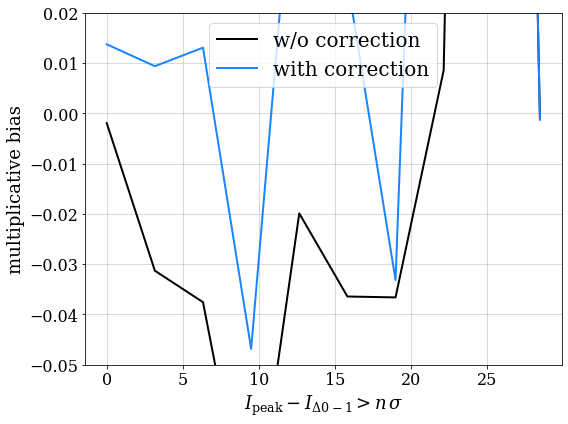

In [25]:
dcc=0.01
x=[]
y1=[]
y2=[]
tt=(2,1)
pn='v%d%d' %tt

if tt != (2,2):
    xlabel=r'$I_{\rm peak}-I_{\Delta %d%d}$' %(tt[0]-2,tt[1]-2)
else:
    xlabel=r'$I_{\rm peak}$'
for i in range(0,10):
    cut=0.2*i
    
    msk1 = (outD1['pdet_%s' %pn]>cut)
    ellM1= outE1[msk1]
    detM1= outD1[msk1]
    del msk1
    
    msk2 = (outD2['pdet_%s' %pn]>cut)
    ellM2= outE2[msk2]
    detM2= outD2[msk2]
    del msk2
    
    cor1,cor1b = get_detbias(detM1,ellM1,cut,dcc,ind=tt)
    cor2,cor2b = get_detbias(detM2,ellM2,cut,dcc,ind=tt)
    cor1=(cor1+cor1b)/2.
    cor2=(cor2+cor2b)/2.
    de   = np.sum(ellM2['fpfs_e1'])-np.sum(ellM1['fpfs_e1'])
    rave = (np.sum(ellM2['fpfs_RE'])+np.sum(ellM1['fpfs_RE']))/2.
    raveR= (np.sum(ellM2['fpfs_RE'])+np.sum(ellM1['fpfs_RE'])+cor1+cor2)/2.
    x.append(cut/np.sqrt(4e-3))
    y1.append(de/rave/0.04-1)
    y2.append(de/raveR/0.04-1)
    del ellM1,detM1,ellM2,detM2
gc.collect()
plt.close()
fig,axes=pltutil.make_figure_axes(1,1)
ax=axes[0]
ax.plot(np.array(x),np.array(y1),label='w/o correction',color=pltutil.colors[0])
ax.plot(np.array(x),np.array(y2),label='with correction',color=pltutil.colors[1])
ax.set_xlabel(xlabel+r'$>n\,\sigma$')
ax.set_ylabel('multiplicative bias')
ax.set_ylim(-0.05,0.02)
ax.grid()
ax.legend()
plt.tight_layout()
#fig.savefig('../../html/noisy_knownRef_%s.png' %pn)

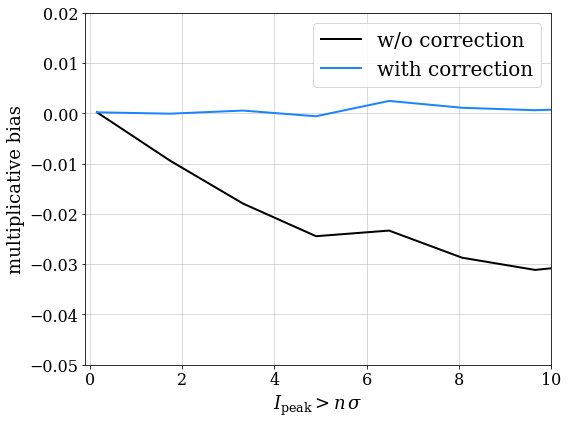

In [66]:
tt = (2,2)
x=[]
y1=[]
y2=[]
pn='v%d%d' %tt

plt.close()
fig,axes=pltutil.make_figure_axes(1,1)
ax=axes[0]
    
if tt != (2,2):
    xlabel=r'$I_{\rm peak}-I_{\Delta %d%d}$' %(tt[0]-2,tt[1]-2)
    ax.set_xlim(-0.1,2)
    dcc=0.0005
    dcut=0.01
else:
    xlabel=r'$I_{\rm peak}$'
    ax.set_xlim(-0.1,10)
    dcc=0.005
    dcut=0.1
    
for i in range(0,10):
    cut=dcut*i+0.01
    
    msk1 = (outDNN1['pdet_%s' %pn]>cut)
    ellM1= outENN1[msk1]
    detM1= outDNN1[msk1]
    del msk1
    
    msk2 = (outDNN2['pdet_%s' %pn]>cut)
    ellM2= outENN2[msk2]
    detM2= outDNN2[msk2]
    del msk2
    
    cor1,cor1b = get_detbias(detM1,ellM1,cut,dcc,ind=tt)
    cor2,cor2b = get_detbias(detM2,ellM2,cut,dcc,ind=tt)
    cor1=(cor1+cor1b)/2.
    cor2=(cor2+cor2b)/2.
    de   = np.sum(ellM2['fpfs_e1'])-np.sum(ellM1['fpfs_e1'])
    rave = (np.sum(ellM2['fpfs_RE'])+np.sum(ellM1['fpfs_RE']))/2.
    raveR= (np.sum(ellM2['fpfs_RE'])+np.sum(ellM1['fpfs_RE'])+cor1+cor2)/2.
    x.append(cut/np.sqrt(4e-3))
    y1.append(de/rave/0.04-1)
    y2.append(de/raveR/0.04-1)
    del detM1,ellM2,detM2
gc.collect()
ax.plot(np.array(x),np.array(y1),label='w/o correction',color=pltutil.colors[0])
ax.plot(np.array(x),np.array(y2),label='with correction',color=pltutil.colors[1])
ax.set_xlabel(xlabel+r'$>n\,\sigma$')
ax.set_ylabel('multiplicative bias')
ax.set_ylim(-0.05,0.02)
ax.grid()
ax.legend()
plt.tight_layout()
#fig.savefig('../../html/noisy_knownRef_%s.png' %pn)

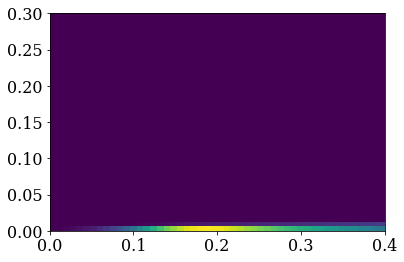

In [27]:
_=plt.hist2d(outE1['fpfs_s0'],outD1['pdet_v21'],range=[[0,0.4],[0,0.3]],bins=50)

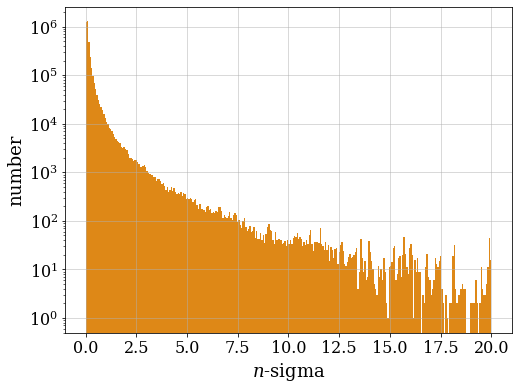

In [28]:
plt.close()
fig,axes=pltutil.make_figure_axes(1,1)
ax=axes[0]
ax.hist(outD1['pdet_%s' %pn]/np.sqrt(4e-3),range=(0,20),bins=300,color=pltutil.colors[-1])
ax.set_yscale('log')
ax.set_xlabel(r'$n$-sigma')
ax.set_ylabel('number')
ax.grid()

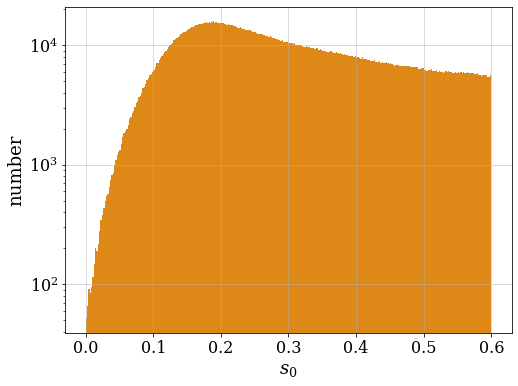

In [29]:
plt.close()
fig,axes=pltutil.make_figure_axes(1,1)
ax=axes[0]
ax.hist(outE1['fpfs_s0'],range=(0,0.6),bins=300,color=pltutil.colors[-1])
ax.set_yscale('log')
ax.set_xlabel(r'$s_0$')
ax.set_ylabel('number')
ax.grid()

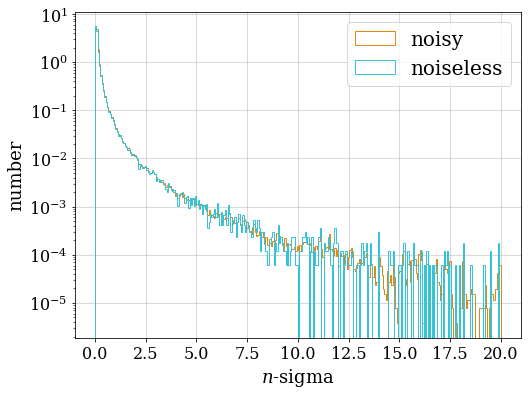

In [30]:
if True:
    plt.close()
    fig,axes=pltutil.make_figure_axes(1,1)
    ax=axes[0]
    h1,g1,_=ax.hist(outD1['pdet_%s' %pn]/np.sqrt(4e-3),range=(0,20),bins=300,color=pltutil.colors[-1],histtype='step',label='noisy',density=True)
    h2,g2,_=ax.hist(outDNN1['pdet_%s' %pn]/np.sqrt(4e-3),range=(0,20),bins=300,color=pltutil.colors[-2],histtype='step',label='noiseless',density=True)
    ax.set_yscale('log')
    ax.set_xlabel(r'$n$-sigma')
    ax.set_ylabel('number')
    ax.grid()
    ax.legend()

if False:
    plt.plot(g1[1:],(h2-h1)/h2)
    plt.xlim(1,10)

20430.331533611683
0.0
25718.621048403184
0.0
10745.596855560321
0.0
14675.053515746604
0.0
7672.821464856074
0.0
9368.29381622692
0.0
5435.370912444759
0.0
7155.484288082273
0.0
4225.473414588545
0.0
5877.664039402106
0.0
2112.052963579698
0.0
3829.3831347360524
0.0
2492.78181557624
0.0
3654.780605219521
0.0
2576.3921972587004
0.0
3680.054740508235
0.0
1364.9978672888012
0.0
1959.47681212028
0.0
1463.4793604452302
0.0
1619.5698852176995
0.0
722.6244814149001
0.0
1288.7718810557967
0.0
381.23388008844626
0.0
1151.618490180912
0.0
1257.1621610302318
0.0
874.6414952160814
0.0
1024.4785317992569
0.0
1279.2349814407341
0.0
381.5185944132476
0.0
1306.9761217326961
0.0
1042.6622007442509
0.0
1046.3137642268755
0.0
530.1455855009183
0.0
695.8803318936042
0.0
403.58774009783053
0.0
736.1840391785546
0.0
449.19176187642427
0.0
708.8768530782883
0.0
189.44143115559388
0.0
333.26344601749287
0.0


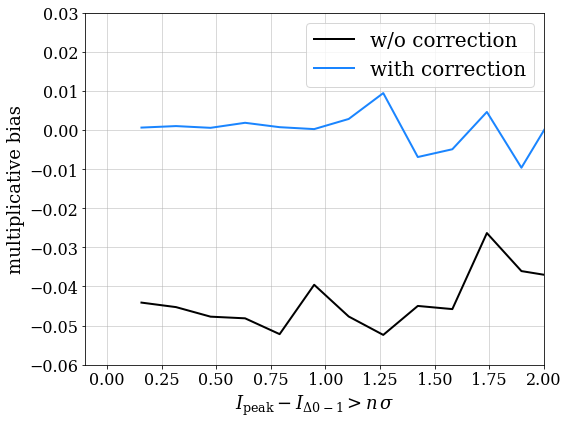

In [57]:
x=[]
y1=[]
y2=[]
tt=(2,1)
pn='v%d%d' %tt
cuts=-10.00

plt.close()
fig,axes=pltutil.make_figure_axes(1,1)
ax=axes[0]

if tt != (2,2):
    xlabel=r'$I_{\rm peak}-I_{\Delta %d%d}$' %(tt[0]-2,tt[1]-2)
    ax.set_xlim(-0.1,2)
    dcc=0.0005
    dcut=0.01
else:
    xlabel=r'$I_{\rm peak}$'
    ax.set_xlim(-0.1,10)
    dcc=0.005
    dcut=0.1
for i in range(0,20):
    cut=dcut*i+0.01
    
    msk1 = (outD1['pdet_%s' %pn]>cut)&(outE1['fpfs_s0']>cuts)
    ellM1= outE1[msk1]
    detM1= outD1[msk1]
    del msk1
    
    msk2 = (outD2['pdet_%s' %pn]>cut)&(outE2['fpfs_s0']>cuts)
    ellM2= outE2[msk2]
    detM2= outD2[msk2]
    del msk2
    
    cor1 = get_detbias_all(detM1,ellM1,cut,cuts,dcc,ind=tt)[0]
    cor2 = get_detbias_all(detM2,ellM2,cut,cuts,dcc,ind=tt)[0]
    de   = np.sum(ellM2['fpfs_e1'])-np.sum(ellM1['fpfs_e1'])
    rave = (np.sum(ellM2['fpfs_RE'])+np.sum(ellM1['fpfs_RE']))/2.
    raveR= (np.sum(ellM2['fpfs_RE'])+np.sum(ellM1['fpfs_RE'])+cor1+cor2)/2.
    x.append(cut/np.sqrt(4e-3))
    y1.append(de/rave/0.04-1)
    y2.append(de/raveR/0.04-1)
    del detM1,ellM2,detM2
gc.collect()
ax.plot(np.array(x),np.array(y1),label='w/o correction',color=pltutil.colors[0])
ax.plot(np.array(x),np.array(y2),label='with correction',color=pltutil.colors[1])
ax.set_xlabel(xlabel+r'$>n\,\sigma$')
ax.set_ylabel('multiplicative bias')
ax.set_ylim(-0.06,0.03)
ax.grid()
ax.legend()
plt.tight_layout()
#fig.savefig('../../html/noisy_knownRef_%s.png' %pn)